## Why Spark for Machine Learning?
- Spark is a unified analytics engine that provides an ecosystem for data ingestion, feature engineering, model training, and deployment. Without Spark, developers would
need many disparate tools to accomplish this set of tasks, and might still struggle with
scalability.
<br>
- Spark has two machine learning packages: <b>spark.mllib</b> and <b>spark.ml</b>. <b>spark.mllib</b>
is the original machine learning API, <b>based on the RDD API</b> (which has been in
maintenance mode since Spark 2.0), while <b>spark.ml</b> is the <b><i>newer</b></i> API, <b>based on DataFrames</b>. We will focus on using the <b>spark.ml</b> package and how to
design machine learning pipelines in Spark. However, we use “MLlib” as an umbrella
term to refer to both machine learning library packages in Apache Spark.
- With spark.ml , data scientists can use one ecosystem for their data preparation and
model building, without the need to downsample their data to fit on a single
machine.
- Spark.ml focuses on O(n) scale-out, where the model scales linearly with
the number of data points you have, so it can scale to massive amounts of data.

## Designing Machine Learning Pipelines
- The concept of
pipelines is common across many ML frameworks as a way to organize a series of
operations to apply to your data.
- In <b>MLlib, the Pipeline API</b> provides a high-level API
built on top of DataFrames to organize your machine learning workflow.
- The Pipeline API is composed of a series of <b>transformers and estimators</b>.

<b>Throughout this session, we will use the San Francisco housing data set from Inside
Airbnb. It contains information about Airbnb rentals in San Francisco, such as the
number of bedrooms, location, review scores, etc., and our goal is to build a model to
predict the nightly rental prices for listings in that city. This is a regression problem,
because price is a continuous variable. We will guide you through the workflow a data
scientist would go through to approach this problem, including feature engineering,building models, hyperparameter tuning, and evaluating model performance.</b><br><br>
<b><font color='red'>Note: </font></b>This
data set is quite messy and can be difficult to model (like most real-world data sets!),
so if you are experimenting on your own, don’t feel bad if your early models aren’t
great.

The intent of this session is not to show you every API in MLlib, but rather to equip
you with the skills and knowledge to get started with using MLlib to build end-to-end
pipelines.

## MLlib terminology:

### Transformer
- Accepts a DataFrame as input, and returns a new DataFrame with one or more
columns appended to it. 
- Transformers do not learn any parameters from your data and simply apply rule-based transformations to either
    - <b>prepare data for model training</b> or
    - <b>generate predictions using a trained MLlib model.</b> 
- They have <b>a .transform()</b> method.

### Estimator
- <b>Learns (or “fits”)</b> parameters from your DataFrame via <b>a .fit()</b> method and
returns a Model , which is a transformer.

### Pipeline
- Organizes a series of transformers and estimators into a single model. While
pipelines themselves are estimators, the output of pipeline.fit() returns a Pipeline Model , a transformer.

## Data Preparation and Exploration

### The used data is slightly preprocessed as follow:   <i><font color='green'>(you can try by yourself)</font><i/>
- Outliers are removed (e.g., Airbnbs posted for $0/night).
- All integers are converted to doubles.
- An informative subset of the more than one hundred fields.
- For any missing numerical values in the data columns, the median value is imputed and added
an indicator column (the column name followed by _na , such as bedrooms_na ). This way the ML model or human analyst can interpret any value in that column as an imputed value, not a true value. 

In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('Mllib').getOrCreate()

In [4]:
airbnbDF = spark.read.parquet('sf-airbnb-clean.parquet/')

In [5]:
airbnbDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [6]:
airbnbDF.select('bedrooms','bedrooms_na').where('bedrooms_na !=0.0').show()

+--------+-----------+
|bedrooms|bedrooms_na|
+--------+-----------+
|     1.0|        1.0|
|     1.0|        1.0|
+--------+-----------+



In [7]:
airbnbDF.select('bathrooms','bathrooms_na').where('bathrooms_na !=0.0').show()

+---------+------------+
|bathrooms|bathrooms_na|
+---------+------------+
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
|      1.0|         1.0|
+---------+------------+
only showing top 20 rows



In [8]:
airbnbDF.select('review_scores_value','review_scores_value_na').where('review_scores_value_na !=0.0').show()

+-------------------+----------------------+
|review_scores_value|review_scores_value_na|
+-------------------+----------------------+
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|               10.0|                   1.0|
|         

In [9]:
airbnbDF.select('review_scores_value','review_scores_value_na').show()

+-------------------+----------------------+
|review_scores_value|review_scores_value_na|
+-------------------+----------------------+
|               10.0|                   0.0|
|                9.0|                   0.0|
|                8.0|                   0.0|
|                9.0|                   0.0|
|                9.0|                   0.0|
|                9.0|                   0.0|
|               10.0|                   0.0|
|               10.0|                   0.0|
|                9.0|                   0.0|
|                9.0|                   0.0|
|                9.0|                   0.0|
|                9.0|                   0.0|
|                7.0|                   0.0|
|                8.0|                   0.0|
|               10.0|                   0.0|
|                9.0|                   0.0|
|               10.0|                   0.0|
|                9.0|                   0.0|
|               10.0|                   0.0|
|         

In [10]:
airbnbDF.select("neighbourhood_cleansed", "room_type", "bedrooms", "bathrooms",
"number_of_reviews", "price").show(5)

+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



In [11]:
airbnbDF.createOrReplaceTempView('airbnbDF_view')
spark.sql('SELECT neighbourhood_cleansed, room_type, bedrooms, bathrooms,number_of_reviews, price FROM airbnbDF_view').show(5)

22/06/04 09:36:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



### Our goal is to predict the price per night for a rental property, given our features.

### Creating Training and Test Data Sets

In [6]:
trainDF, testDF = airbnbDF.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

22/06/04 09:44:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


There are 5780 rows in the training set, and 1366 in the test set


- But what happens if we change the number of executors in our Spark cluster? The
Catalyst optimizer determines the optimal way to partition your data as a function of
your cluster resources and size of your data set. Given that data in a Spark DataFrame
is row-partitioned and each worker performs its split independently of the other
workers, if the data in the partitions changes, then the result of the split (by random
Split() ) won’t be the same.
- While you could fix your cluster configuration and your seed to ensure that you get
consistent results, it is recommended to split your data once, then write it out to
its own train/test folder so you don’t have these reproducibility issues.

<b><font color = 'red'>Note: </font>
During your exploratory analysis, you should cache the training
data set because you will be accessing it many times throughout the
machine learning process.</b>

### Preparing Features with Transformers
- Now that we have split our data into training and test sets, let’s prepare the data to
build a linear regression model predicting price given the number of bedrooms.
-  Linear regression (like many other algorithms in
Spark) requires that all the input features are contained within a single vector in your
DataFrame. Thus, we need to transform our data.
- Transformers in Spark accept a DataFrame as input and return a new DataFrame
with one or more columns appended to it. They do not learn from your data, but
apply rule-based transformations using the transform() method.
- For the task of putting all of our features into a single vector, we will use the <b>VectorAssembler</b> transformer. 
- VectorAssembler takes a list of input columns and creates a new DataFrame with an additional column, which we will call features . It combines the values of those input columns into a single vector.

In [7]:
from pyspark.ml.feature import VectorAssembler

In [14]:
vecAssembler = VectorAssembler(inputCols=['bedrooms'],outputCol='features')

In [15]:
vecAssembler

VectorAssembler_e638a0585248

In [16]:
vectTrainDF = vecAssembler.transform(trainDF)

In [17]:
vectTrainDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [18]:
vectTrainDF.select('bedrooms','features','price').show(5)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]|200.0|
|     1.0|   [1.0]|130.0|
|     1.0|   [1.0]| 95.0|
|     1.0|   [1.0]|250.0|
|     3.0|   [3.0]|250.0|
+--------+--------+-----+
only showing top 5 rows



### Using Estimators to Build Models
- After setting up our vectorAssembler , we have our data prepared and transformed into a format that our linear regression model expects.
- In Spark, <b>LinearRegression</b> is a type of <b>estimator</b>—it takes in a <b>DataFrame</b> and returns a <b>Model</b>.
- Estimators learn parameters from your data, have an <b>estimator_name.fit()</b> method.

<b><font color = 'red'>Note: </font>Estimators are eagerly evaluated (i.e., kick off Spark jobs), whereas transformers are lazily evaluated.</b>

In [8]:
from pyspark.ml.regression import LinearRegression

In [20]:
lr = LinearRegression(featuresCol='features',labelCol='price',predictionCol='prediction')

In [21]:
lr

LinearRegression_9f6a8be18deb

In [22]:
lrModel = lr.fit(vectTrainDF)

22/06/04 09:36:43 WARN Instrumentation: [1b6fa6dd] regParam is zero, which might cause numerical instability and overfitting.


- <b>lr.fit()</b> returns a <b>LinearRegressionModel ( lrModel )</b>, which is a <b>transformer</b>. In other words, the output of an estimator’s <b>fit()</b> method is a <b>transformer</b>.
- Once the estimator has learned the parameters, the transformer can apply these parameters to new data points to generate predictions.

In [23]:
m =round(lrModel.coefficients[0],2)
b = round(lrModel.intercept,2)
print(f"The formula for the linear regression line is \033[1m price = {b} + {m}*bedrooms \033[0m")

The formula for the linear regression line is  price = 47.51 + 123.68*bedrooms 


## Creating a Pipeline
- If we want to apply our model to our test set, then we need to prepare that data in the same way as the training set (i.e., pass it through the vector assembler).
- Oftentimes data preparation pipelines will have multiple steps, and it becomes cumbersome to remember not only which steps to apply, but also the ordering of the steps.
- This is the motivation for the Pipeline API: you simply specify the stages you want your data to pass through, in order, and Spark takes care of the processing for you.
- They provide the user with better code reusability and organization.
- In Spark, <b>Pipelines are estimators, whereas PipelineModels—fitted Pipelines—are transformers</b>.

In [9]:
# Building the pipeline
from pyspark.ml import Pipeline

In [25]:
pipeline = Pipeline(stages=[vecAssembler,lr])

In [26]:
pipelineModel = pipeline.fit(trainDF)

22/06/04 09:36:46 WARN Instrumentation: [71fce171] regParam is zero, which might cause numerical instability and overfitting.


- Another advantage of using the Pipeline API is that it determines which stages are <b>estimators/transformers</b> for you, so you don’t have to worry about specifying <b>name.fit()</b> versus <b>name.transform()</b> for each of the stages.
- Since pipelineModel is a transformer, it is straightforward to apply it to our test data set too:

In [27]:
predDF = pipelineModel.transform(testDF)

In [28]:
predDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [29]:
predDF.select("bedrooms",'features','price','prediction').show(10)

+--------+--------+------+------------------+
|bedrooms|features| price|        prediction|
+--------+--------+------+------------------+
|     1.0|   [1.0]|  85.0|171.18598011578285|
|     1.0|   [1.0]|  45.0|171.18598011578285|
|     1.0|   [1.0]|  70.0|171.18598011578285|
|     1.0|   [1.0]| 128.0|171.18598011578285|
|     1.0|   [1.0]| 159.0|171.18598011578285|
|     2.0|   [2.0]| 250.0|294.86172649777757|
|     1.0|   [1.0]|  99.0|171.18598011578285|
|     1.0|   [1.0]|  95.0|171.18598011578285|
|     1.0|   [1.0]| 100.0|171.18598011578285|
|     1.0|   [1.0]|2010.0|171.18598011578285|
+--------+--------+------+------------------+
only showing top 10 rows



## Multivariable Linear Regression
In the pipeline we just created, we only had two stages, and our linear regression
model only used one feature. Let’s take a look at how to build a slightly more complex
pipeline that incorporates all of our numeric and categorical features.

### One-hot encoding
- Most machine learning models in MLlib expect numerical values as input, represented as vectors.
- To convert categorical values into numeric values, we can use a
technique called <b>one-hot encoding (OHE)</b>.
- Suppose we have a column called Animal
and we have three types of animals: Dog , Cat , and Fish . We can’t pass the string types
into our ML model directly, so we need to assign a numeric mapping, such as this:<br>
<center><b>Animal = {"Dog", "Cat", "Fish"}</b></center>
<center><b>"Dog" = 1, "Cat" = 2, "Fish" = 3</b></center>
- However, using this approach we’ve introduced some <b>spurious relationships</b> into our
data set that weren’t there before. For example, <b>why did we assign Cat twice the value
of Dog ?</b> The numeric values we use should not introduce any relationships into our
data set. Instead, we want to create a separate column for every distinct value in our
Animal column:
<center><b>"Dog" = [ 1, 0, 0]</b></center>
<center><b>"Cat" = [ 0, 1, 0]</b></center>
<center><b>"Fish" = [0, 0, 1]</b></center>
If the animal is a dog, it has a one in the first column and zeros elsewhere. If it is a cat,
it has a one in the second column and zeros elsewhere. The ordering of the columns
is irrelevant. It is as <b>pandas.get_dummies()</b>.<br>
If we had a zoo of <b>300 animals</b>, would <b>OHE</b> massively increase consumption of memory/compute resources? <b><i>Not with Spark!</i></b> Spark internally uses a <b>SparseVector</b> when
the majority of the entries are 0 , <i>as is often the case after OHE</i>, so it does not waste
space storing 0 values. Let’s take a look at an example to better understand how
SparseVector s work:
<center><b>DenseVector(0, 0, 0, 7, 0, 2, 0, 0, 0, 0)</b></center>
<center><b>SparseVector(10, [3, 5], [7, 2])</b></center>
The <b>DenseVector</b> in this example contains 10 values, all but 2 of which are 0 . To create a SparseVector , we need to keep track of the size of the vector, the indices of the
nonzero elements, and the corresponding values at those indices. <i>In this example the
size of the vector is 10, there are two nonzero values at indices 3 and 5, and the corresponding values at those indices are 7 and 2.</i><br>
<br>A common approach to one-hot encode your data with Spark is to use the <b>StringIndexer and OneHotEncoder</b>. With this approach, the first step is to
apply the <b>StringIndexer <i>estimator<i></b> to convert categorical values into category indices. These category indices are ordered by label frequencies, so the most frequent
label gets index 0, which provides us with reproducible results across various runs of
the same data.<br>
Once you have created your category indices, you can pass those as input to the
<b>OneHotEncoder</b>. The <b>OneHotEncoder<i> (estimator)</i></b> maps a column of category indices to a column of binary vectors. 

<b><font color='red'>Note: </font> In our data set, any column of type string is treated as a categorical feature, but sometimes you might have numeric features you want treated as categorical or vice versa.</b>

In [64]:
import pandas as pd

In [34]:
s = pd.Series(list('abca'))

In [35]:
s

0    a
1    b
2    c
3    a
dtype: object

In [66]:
pd.get_dummies(s)

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0


In [65]:
pd.get_dummies(list('abca'))

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0


In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
enc = OneHotEncoder(handle_unknown='ignore')

In [41]:
import numpy as np

In [54]:
A = np.array(list('abca')).reshape(-1,1)

In [63]:
enc.fit_transform(A).toarray()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [11]:
trainDF.dtypes

[('host_is_superhost', 'string'),
 ('cancellation_policy', 'string'),
 ('instant_bookable', 'string'),
 ('host_total_listings_count', 'double'),
 ('neighbourhood_cleansed', 'string'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('property_type', 'string'),
 ('room_type', 'string'),
 ('accommodates', 'double'),
 ('bathrooms', 'double'),
 ('bedrooms', 'double'),
 ('beds', 'double'),
 ('bed_type', 'string'),
 ('minimum_nights', 'double'),
 ('number_of_reviews', 'double'),
 ('review_scores_rating', 'double'),
 ('review_scores_accuracy', 'double'),
 ('review_scores_cleanliness', 'double'),
 ('review_scores_checkin', 'double'),
 ('review_scores_communication', 'double'),
 ('review_scores_location', 'double'),
 ('review_scores_value', 'double'),
 ('price', 'double'),
 ('bedrooms_na', 'double'),
 ('bathrooms_na', 'double'),
 ('beds_na', 'double'),
 ('review_scores_rating_na', 'double'),
 ('review_scores_accuracy_na', 'double'),
 ('review_scores_cleanliness_na', 'double'),
 ('review_sco

In [12]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes
                  if dataType == 'string']

In [13]:
categoricalCols

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [14]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
indexOutputCols

['host_is_superhost_Index',
 'cancellation_policy_Index',
 'instant_bookable_Index',
 'neighbourhood_cleansed_Index',
 'property_type_Index',
 'room_type_Index',
 'bed_type_Index']

In [15]:
oheOutputCols = [x + "_OHE" for x in categoricalCols]
oheOutputCols

['host_is_superhost_OHE',
 'cancellation_policy_OHE',
 'instant_bookable_OHE',
 'neighbourhood_cleansed_OHE',
 'property_type_OHE',
 'room_type_OHE',
 'bed_type_OHE']

In [16]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                              outputCols=indexOutputCols,
                             handleInvalid='skip')

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

In [17]:
numericCols = [field for (field,dataType) in trainDF.dtypes
              if ((dataType=='double')&(field!='price'))]
numericCols

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

In [18]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

['host_is_superhost_OHE',
 'cancellation_policy_OHE',
 'instant_bookable_OHE',
 'neighbourhood_cleansed_OHE',
 'property_type_OHE',
 'room_type_OHE',
 'bed_type_OHE',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

In [19]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

- Now you might be wondering, “How does the StringIndexer handle new categories that appear in the test data set, but not in the training data set?” 
- There is a handleInvalid parameter that specifies how you want to handle them. 
- The option are <b><i>skip (filter out rows with invalid data), error (throw an error), or keep (put invalid data in a special additional bucket, at index numLabels )</b></i>. 
- For this example, we just skipped the invalid records.
- <b>For more information and detailed explanation check the following resources:</b><br>
https://stackoverflow.com/questions/34681534/spark-ml-stringindexer-handling-unseen-labels<br>
https://spark.apache.org/docs/latest/ml-features.html#stringindexer

In [20]:
lr = LinearRegression(featuresCol='features',
                      labelCol='price',
                      predictionCol='prediction')

In [21]:
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,
                           vecAssembler,lr])

In [22]:
pipelineModel = pipeline.fit(trainDF)

22/06/04 09:48:52 WARN Instrumentation: [86af098a] regParam is zero, which might cause numerical instability and overfitting.


In [23]:
predDF = pipelineModel.transform(testDF)

In [24]:
predDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [25]:
predDF.select('cancellation_policy','cancellation_policy_Index','cancellation_policy_OHE').show()

+-------------------+-------------------------+-----------------------+
|cancellation_policy|cancellation_policy_Index|cancellation_policy_OHE|
+-------------------+-------------------------+-----------------------+
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],[1.0])|
|           flexible|                      2.0|          (5,[2],

In [26]:
predDF.select('features','price','prediction').show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(98,[0,3,6,22,43,...| 85.0| 55.24365707389188|
|(98,[0,3,6,22,43,...| 45.0|23.357685914717877|
|(98,[0,3,6,22,43,...| 70.0|28.474464479034395|
|(98,[0,3,6,12,42,...|128.0| -91.6079079594947|
|(98,[0,3,6,12,43,...|159.0| 95.05688229945372|
+--------------------+-----+------------------+
only showing top 5 rows



In [28]:
predDF.select('features','price','prediction').show(1,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------+
|features                                                                                                                                                                                  |price|prediction       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------+
|(98,[0,3,6,22,43,66,68,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,37.72001,-122.39249,2.0,1.0,1.0,1.0,2.0,128.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0])|85.0 |55.24365707389188|
+---------------------------------------------------------------------------------------------------------------------------------------------------

### Model Evaluation

In [29]:
# Using RMSE
from pyspark.ml.evaluation import RegressionEvaluator

In [30]:
regressionEvaluator = RegressionEvaluator(predictionCol='prediction',
                                         labelCol='price',
                                         metricName='rmse')

In [31]:
rmse = regressionEvaluator.evaluate(predDF)

In [32]:
print(f"RMSE is {rmse:.1f}")

RMSE is 220.6


In [33]:
r2 = RegressionEvaluator(predictionCol='prediction',
                                         labelCol='price',
                                         metricName='r2').evaluate(predDF)
print(f"R2 is {r2}")

R2 is 0.16043316698848087


- Our R2 is positive, but it’s very close to 0. One of the reasons why our model is not performing too well is because our label, price , appears to be <b>log-normally distributed</b>.
- If a distribution is log-normal, it means that if we take the logarithm of the
value, the result looks like a normal distribution.
- Price is often log-normally distributed. If you think about rental prices in San Francisco, most cost around $200 per
night, but there are some that rent for thousands of dollars a night!

In [34]:
price  = airbnbDF.select('price').toPandas()

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='price', ylabel='Count'>

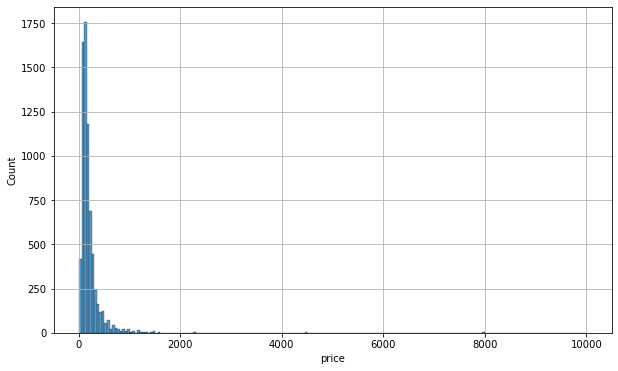

In [43]:
plt.figure(figsize=(10,6))
plt.grid()
sns.histplot(price['price'],bins=200)

<AxesSubplot:>

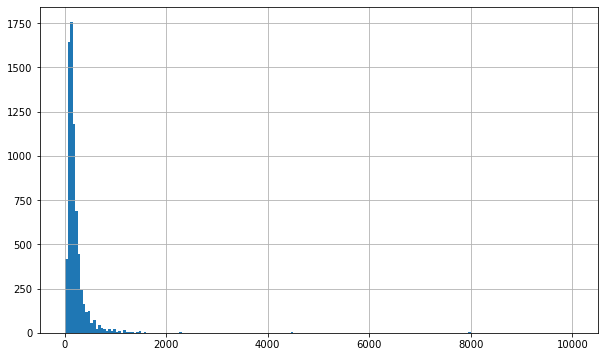

In [41]:
plt.figure(figsize=(10,6))
price['price'].hist(bins=200)

In [44]:
import math

In [48]:
from pyspark.sql.functions import log,col

In [50]:
airbnbDF.select('price',log(col('price')).alias('logprice')).show(5)

+-----+-----------------+
|price|         logprice|
+-----+-----------------+
|170.0|5.135798437050262|
|235.0|5.459585514144159|
| 65.0|4.174387269895637|
| 65.0|4.174387269895637|
|785.0|6.665683717782408|
+-----+-----------------+
only showing top 5 rows



In [51]:
logPrice = airbnbDF.select(log(col('price')).alias('logprice'))

In [53]:
pricelog  = logPrice.select('logprice').toPandas()

<AxesSubplot:xlabel='logprice', ylabel='Count'>

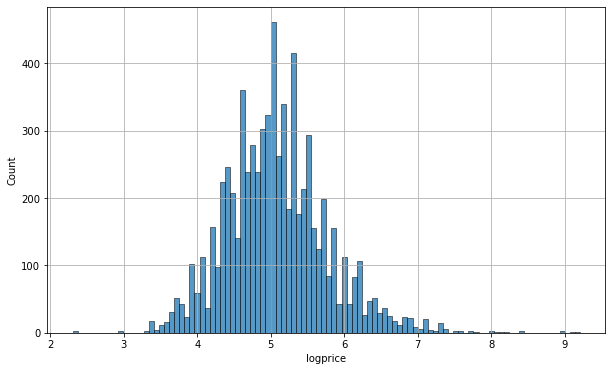

In [56]:
plt.figure(figsize=(10,6))
plt.grid()
sns.histplot(pricelog['logprice'],bins=100)

In [57]:
import math

In [58]:
price['logprice'] = price['price'].apply(math.log)

<AxesSubplot:>

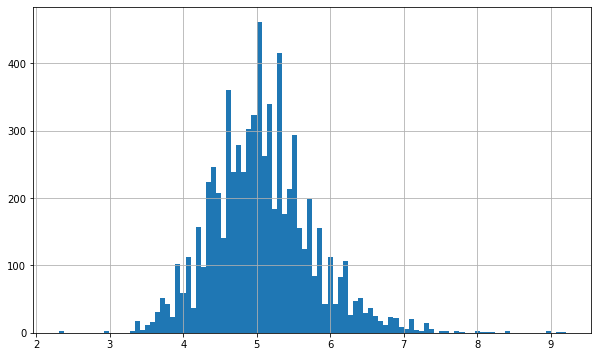

In [60]:
plt.figure(figsize=(10,6))
price['logprice'].hist(bins=100) 

## Exercise:
### Try building a model to predict price on the log scale, then exponentiate the prediction to get it out of log scale and evaluate your model.

### Saving and Loading Models

In [61]:
# Saving the model
pipelinePath = "lr-pipeline-model"
pipelineModel.write().overwrite().save(pipelinePath)

In [62]:
# Loading the model
from pyspark.ml import PipelineModel
savedPipelineModel = PipelineModel.load(pipelinePath)